In [1]:
#Importing the libraries
#Using OpenCV for image processing aand Keras for neural net

from imutils import contours
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from keras.models import model_from_json
from datetime import datetime

def showfig(image, ucmap):
    #There is a difference in pixel ordering in OpenCV and Matplotlib.
    #OpenCV follows BGR order, while matplotlib follows RGB order.
    if len(image.shape)==3 :
        b,g,r = cv2.split(image)       # get b,g,r
        image = cv2.merge([r,g,b])     # switch it to rgb
    imgplot=plt.imshow(image, ucmap)

C:\Users\manth\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


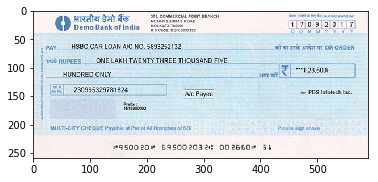

In [2]:
#Open image
image = cv2.imread("cheque.jpg")
showfig(image, None)

In [3]:
# initialize a rectangular and square structuring kernel
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

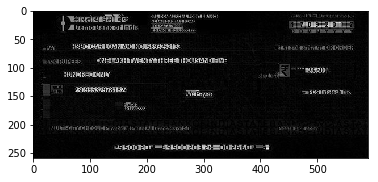

In [4]:
# load the input image, resize it, and convert it to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)
showfig(tophat, plt.get_cmap('gray'))

In [5]:
# compute the Scharr gradient of the tophat image in X direction, then scale the rest back into the range [0, 255]
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0,ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")

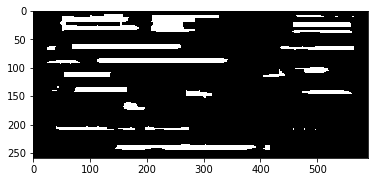

In [6]:
# apply a closing operation using the rectangular kernel to help close gaps in between cheque details, then apply Otsu's thresholding method to binarize the image
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
 
# apply a second closing operation to the binary image, again to help close gaps between cheque details
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
showfig(thresh, plt.get_cmap('gray'))

In [7]:
# find contours in the thresholded image
_, contours, _ =cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

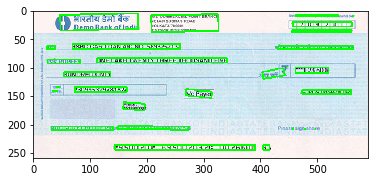

In [8]:
# loop over the contours to plot all the contours over cheque image
img_box=image.copy()
for cnt in contours:
    rect=cv2.minAreaRect(cnt)  
    box=cv2.boxPoints(rect) 
    box=np.int0(box)
    cv2.drawContours(img_box, [box], 0, (0,255,0),2)
showfig(img_box, None)

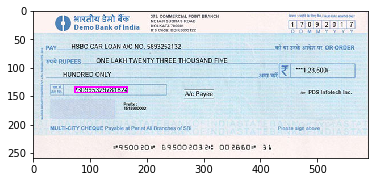

In [9]:
#Finding the relvant box (Account number) based on the approximate shape

for contour in contours:
    [x,y,w,h] = cv2.boundingRect(contour)
    if (w > 90 and w < 100) and (h > 8 and h < 11):
        [X,Y,W,H]=[x,y,w,h]
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255), 2)
    
showfig(image, None)

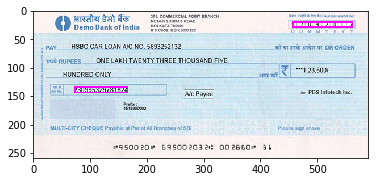

In [10]:
#Finding the relvant box (Cheque Date) based on the approximate shape

for contour in contours:
    [x1,y1,w1,h1] = cv2.boundingRect(contour)
    if (w1 > 100 and w1 < 150) and (h1 > 7 and h1 < 12):
        [X1,Y1,W1,H1]=[x1,y1,w1,h1]
        cv2.rectangle(image,(x1,y1),(x1+w1,y1+h1),(255,0,255), 2)
  
showfig(image, None)

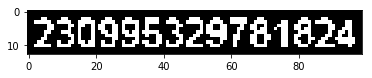

In [11]:
# Extracting the account number part and convert it into black and white for digit extraction and recognition
img=cv2.imread("cheque.jpg")[Y-2:Y+H+2, X-3:X+W+3]
gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
(thresh, crop_img)=cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU )
showfig(crop_img, plt.get_cmap('gray'))

In [12]:
#Finding contours on account number box
im2,ctrs, hier = cv2.findContours(crop_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#sort contours
sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])

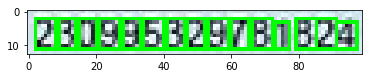

In [13]:
#Finding the indivisual account number and then create the test data cotaining all the account numbers
temp = []

for i, ctr in enumerate(sorted_ctrs):
    # Get bounding box
    x, y, w, h = cv2.boundingRect(ctr)
 
    # Getting ROI
    roi = crop_img[y-1:y+h+1, x-1:x+w+1]
    img_temp = cv2.resize(roi, dsize=(28,28), interpolation = cv2.INTER_CUBIC)
    temp.append(img_temp)
    
    # show ROI
    cv2.rectangle(img,(x,y),( x + w, y + h ),(0,255,0),1)

showfig(img, plt.get_cmap('gray'))

test_account = np.stack(temp)
test_account = test_account.reshape(test_account.shape[0], 1,28, 28).astype('float32')/ 255    

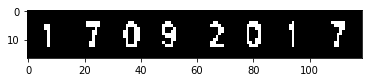

In [14]:
# Extracting the account number part and convert it into black and white for digit extraction and recognition
img_date=cv2.imread("cheque.jpg")[Y1-4:Y1+H1+4, X1-7:X1+W1+7]
gray_date=cv2.cvtColor(img_date, cv2.COLOR_BGR2GRAY)
_, crop_img_date=cv2.threshold(gray_date,160,255,cv2.THRESH_BINARY_INV)
showfig(crop_img_date, plt.get_cmap('gray'))

In [15]:
#Finding contours on date box
im2,ctrs, hier = cv2.findContours(crop_img_date.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#sort contours
sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])

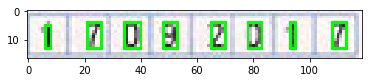

In [16]:
#Finding the indivisual date details and then create the test data cotaining all the date details
temp_date = []

for i, ctr in enumerate(sorted_ctrs):
    # Get bounding box
    x, y, w, h = cv2.boundingRect(ctr)
 
    # Getting ROI
    roi = crop_img_date[y-2:y+h+2, x-3:x+w+3]
    img_temp = cv2.resize(roi, dsize=(28,28), interpolation = cv2.INTER_CUBIC)
    temp_date.append(img_temp)
    
    # show ROI
    cv2.rectangle(img_date,(x,y),( x + w, y + h ),(0,255,0),1)

showfig(img_date, plt.get_cmap('gray'))

test_date = np.stack(temp_date)
test_date = test_date.reshape(test_date.shape[0], 1,28, 28).astype('float32')/ 255

In [17]:
# Using hand writing recognition model for digit recognition
# load json and create model
json_file = open('model_final.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_final.h5")
print("Loaded model from disk")

Loaded model from disk


In [18]:
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
#Predicting the account number with accuracy
predictions_a = loaded_model.predict_classes(test_account)
Account_Number=int(''.join(predictions_a.astype(str)))
print("Customer account number is:%i " %Account_Number)

actual_account=[2,3,0,9,9,5,3,2,9,7,8,1,8,2,4]
c=0
for i in range(len(actual_account)):
    if predictions_a[i]==actual_account[i]:
        c=c+1
        
accuracy=(c*100/len(actual_account))
print("Accuracy of account number prediction is: %.2f " %accuracy)

Customer account number is:230995329787824 
Accuracy of account number prediction is: 93.33 


In [20]:
#Predicting the date with accuracy
predictions_d = loaded_model.predict_classes(test_date)
date=''.join(predictions_d.astype(str))
cheque_date = str(date[0:2]+'-'+date[2:4]+'-'+date[4:8])
print("Cheque date: %s" %cheque_date)

actual_date=[1,7,0,9,2,0,1,7]
d=0
for i in range(len(actual_date)):
    if predictions_d[i]==actual_date[i]:
        d=d+1
        
accuracy_date=(d*100/len(actual_date))
print("Accuracy of cheque date prediction is: %.2f " %accuracy_date)

Cheque date: 17-09-2017
Accuracy of cheque date prediction is: 100.00 
